In [1]:
from generator.context import SNVGeneratorContext
from generator.model import SNVModel, CellData
from generator.gen_utils import sample_conditionally_with_replacement, CNEvent, SNVEvent

from typing import List, Tuple
import numpy as np
import random

In [2]:
class GeneratorContext(SNVGeneratorContext):
    def get_max_cn(self) -> int:
        return 9

    def get_b_sampling_error(self) -> float:
        return 0.05

    def get_d_sampling_error(self) -> float:
        return 0.0001

    def get_read_success_probablity(self) -> float:
        return 0.00001

    def get_per_allele_coverage(self) -> float:
        return 0.03

    def get_neutral_cn(self) -> int:
        return 2

    def sample_cn_change(self, event: CNEvent, parent_cn_profile: np.ndarray, overlap_bit_map: np.ndarray) -> int:
        """
            Wyznaczanie zmiany CN przez wydarzenie @event.
            parent_cn_profile - tablica (dlugosc to ilosc binow) trzymajaca CN profile rodzica w drzewie
            overlap_bit_map - tablica (dlugosc to ilosc binow) 0, 1, gdzie oberlap_bit_map[bin] == 1.0 
            oznacza, ze bin jest objety jakims wydarzeniem w potomku wierzcholka @event - a wiec nie moze 
            byc na tym binie calkowitej delecji.
        
        """
        max_amplification = min(2, self.get_max_cn() - max([parent_cn_profile[b] for b in range(event[0], event[1])]))
        max_possible_deletion = -min(2, np.min(parent_cn_profile[[i for i in range(event[0], event[1])]]))
        if np.sum(overlap_bit_map) == 0.0: # No bin is present in child nodes- we can do full deletion
            return sample_conditionally_with_replacement(1, lambda: random.randint(max_possible_deletion, max_amplification + 1), lambda x: x != 0)[0]

        min_cn_in_bins_with_overlap = np.min(parent_cn_profile[overlap_bit_map == 1.0])
        max_possible_deletion = -min(2, int(min_cn_in_bins_with_overlap) - 1)
        return sample_conditionally_with_replacement(1, lambda: random.randint(max_possible_deletion, max_amplification + 1), lambda x: x != 0)[0]


    def get_number_of_bins(self) -> int:
        return 1000

    def get_cn_event_candidates(self) -> List[CNEvent]:
        return [(a, b) for a in range(0, 1000) for b in range(0, 1000) if a < b and b - a < 50]

    def get_snv_event_candidates(self) -> List[SNVEvent]:
        """
            Lista wszystkich mozliwych SNV, mamy jeden SNV per bin, wiec SNV reprezentujemy przez nr bin
        """
        return [i for i in range(0, 1000)]

    def sample_number_of_snvs_for_edge(self, num_available_snvs: int) -> int:
        """
            Losowanie ilosci SVN na krawedzi.
            @num_available_snvs = Ile jest dostepnych SNV 
        """
        return min(num_available_snvs, np.random.poisson(lam=1.0, size=None))

    def get_number_of_alterations(self, cn_before: int, cn_after: int, parent_altered_counts: int) -> int:
        """
            Ile zmutowanych kopii ma byc w binie, ktory przed mutacja mial @cn_before CN, przeszedl mutacje, 
            a nastepnie zmiane CN do @cn_after. 
            
            Na razie jest tak, ze jezeli cn_after > cn_before, to z prawdopodobienstwem 1 / cn_before wszystkie nowe 
            kopie maja mutacje (i jedna zmutowana, z ktorej te nowe sie wziely), przeciwnie tylko 1.
            
            Jezeli cn_after < cn_before to z prawdopodobienstwem cn_after / cn_before 1 przeciwnie 0 (bo kopia z mutacja 
            zostala usunieta)
            
        """
        if cn_after == 0:
            return 0
        if cn_after == cn_before:
            return parent_altered_counts
        if cn_after > cn_before:
            return parent_altered_counts + (cn_after - cn_before) if random.randint(0, cn_before) < parent_altered_counts else parent_altered_counts
        else:
            copies_for_deletion = random.sample(range(0, cn_before), cn_before - cn_after)
            return parent_altered_counts - len([x for x in copies_for_deletion if x < parent_altered_counts])

In [3]:
model = SNVModel(GeneratorContext())
model.generate_structure(10)

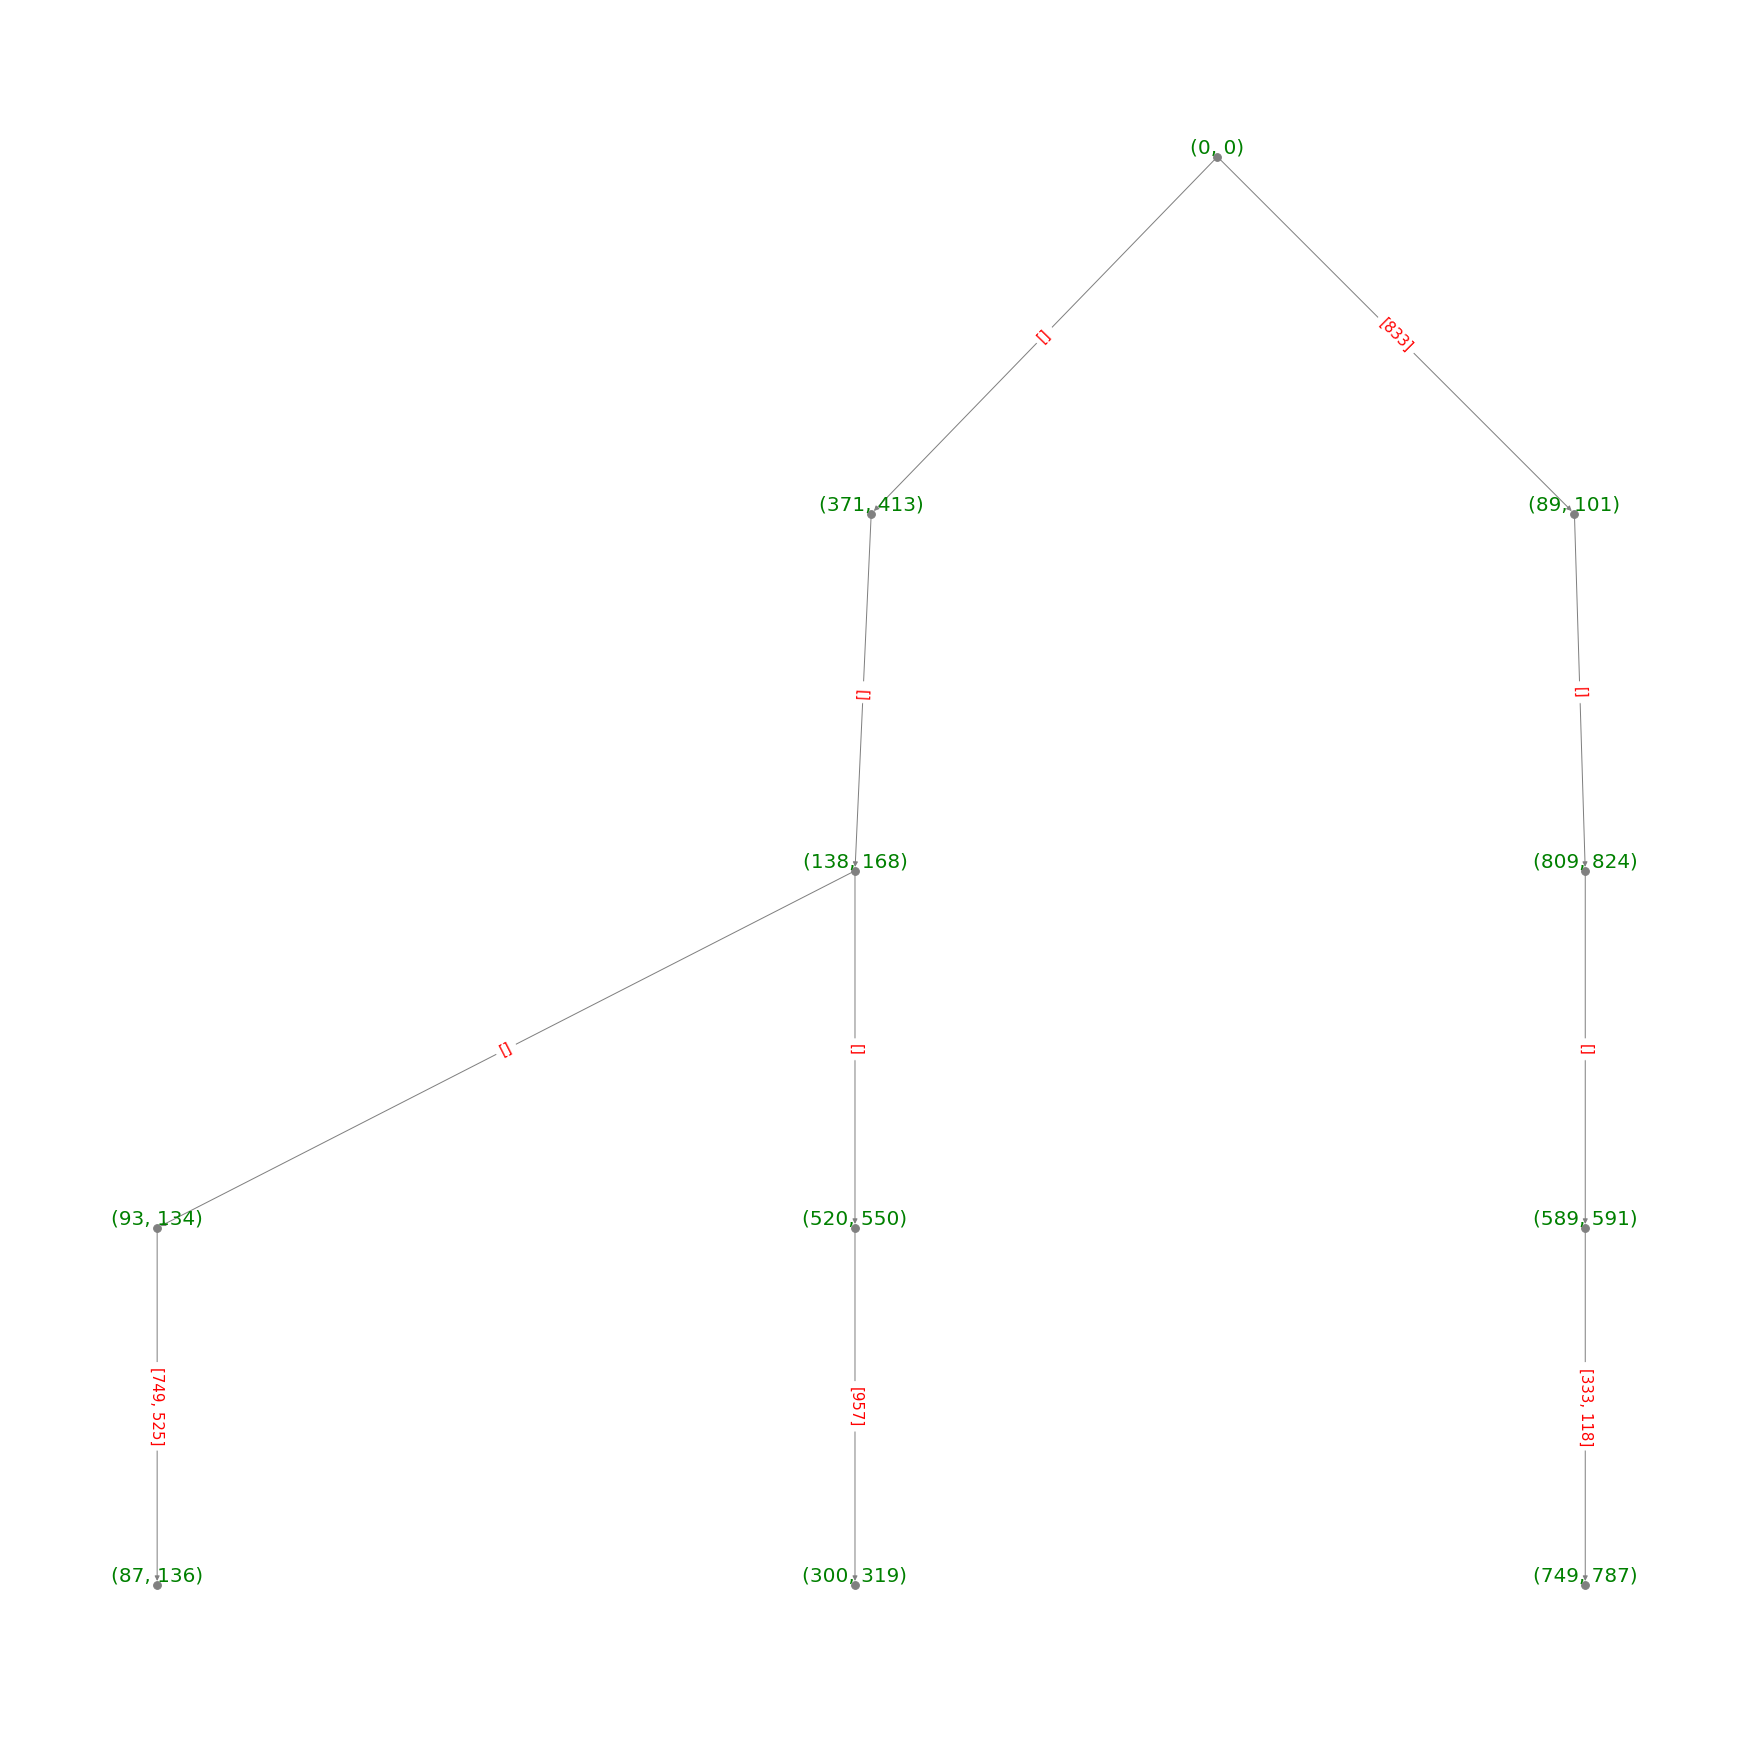

In [4]:
"""
DRAW TREE + SNVs 
"""

from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx 
import json
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(model.event_tree.cn_event_tree, prog="dot")
nx.draw(model.event_tree.cn_event_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")


edge_dict = {} 
for edge in model.event_tree.cn_event_tree.edges: 
    edge_dict[edge] = json.dumps(list(model.event_tree.node_to_snvs[edge[1]]))
nx.draw_networkx_edge_labels(
    model.event_tree.cn_event_tree, pos,
    edge_labels=edge_dict,
    font_color='red', font_size = 15
)
plt.show()

In [5]:
CELLS = 1000

In [6]:
corrected_counts = np.zeros((CELLS, GeneratorContext().get_number_of_bins()))
b = np.zeros((CELLS, GeneratorContext().get_number_of_bins()))
d = np.zeros((CELLS, GeneratorContext().get_number_of_bins()))
counts = np.zeros((CELLS, GeneratorContext().get_number_of_bins()))
attachment = [] 

In [7]:
for i in range(0, CELLS):
    node = next(model.generate_cell_attachment())
    cell = model.generate_cell_in_node(node)
    corrected_counts[i,] = cell.corrected_counts
    b[i, ] = cell.b
    d[i, ] = cell.d
    attachment = attachment + [cell.attachment]
    counts[i, ] = model.node_to_cn_profile[cell.attachment]